In [1]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import torch

from replay.metrics import OfflineMetrics, Recall, Precision, MAP, NDCG, HitRate, MRR
from replay.metrics.torch_metrics_builder import metrics_to_df
from replay.splitters import LastNSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.models.nn.optimizer_utils import FatOptimizerFactory
from replay.models.nn.sequential.callbacks import (
    ValidationMetricsCallback,
    SparkPredictionCallback,
    PandasPredictionCallback, 
    TorchPredictionCallback,
    QueryEmbeddingsPredictionCallback
)
from replay.models.nn.sequential.postprocessors import RemoveSeenItems
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)
from replay.models.nn.sequential import SasRec
from replay.models.nn.sequential.sasrec import (
    SasRecPredictionDataset,
    SasRecTrainingDataset,
    SasRecValidationDataset,
    SasRecPredictionBatch,
    SasRecModel
)

import pandas as pd

In [2]:
# Загрузка данных
user_features = pd.read_csv('data/user_features.csv')
item_features = pd.read_csv('data/item_features.csv')
interactions  = pd.read_csv('data/events.csv')

In [3]:
interactions

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4
...,...,...,...,...
894144,6039,1453,4,223
894145,6039,613,5,224
894146,6039,1548,4,225
894147,6039,241,4,226


In [4]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()

In [5]:
splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
)

raw_test_events, raw_test_gt = splitter.split(interactions)
raw_validation_events, raw_validation_gt = splitter.split(raw_test_events)
raw_train_events = raw_validation_events

In [6]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    all_features = base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )
    return all_features

In [7]:
train_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_train_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)

In [8]:
validation_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_validation_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)
validation_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_validation_gt,
    check_consistency=True,
    categorical_encoded=False,
)

In [9]:
test_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_test_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)
test_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_test_gt,
    check_consistency=True,
    categorical_encoded=False,
)

In [10]:
ITEM_FEATURE_NAME = "item_id_seq"

tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name=ITEM_FEATURE_NAME,
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[TensorFeatureSource(FeatureSource.INTERACTIONS, train_dataset.feature_schema.item_id_column)],
        feature_hint=FeatureHint.ITEM_ID,
    )
)

In [11]:
tokenizer = SequenceTokenizer(tensor_schema, allow_collect_to_master=True)
tokenizer.fit(train_dataset)

sequential_train_dataset = tokenizer.transform(train_dataset)

sequential_validation_dataset = tokenizer.transform(validation_dataset)
sequential_validation_gt = tokenizer.transform(validation_gt, [tensor_schema.item_id_feature_name])

sequential_validation_dataset, sequential_validation_gt = SequentialDataset.keep_common_query_ids(
    sequential_validation_dataset, sequential_validation_gt
)

In [12]:
test_query_ids = test_gt.query_ids
test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)["user_id"].values
sequential_test_dataset = tokenizer.transform(test_dataset).filter_by_query_id(test_query_ids_np)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

count    6040.000000
mean      148.037914
std       173.461681
min        14.000000
25%        38.000000
50%        84.500000
75%       186.000000
max      2056.000000
dtype: float64


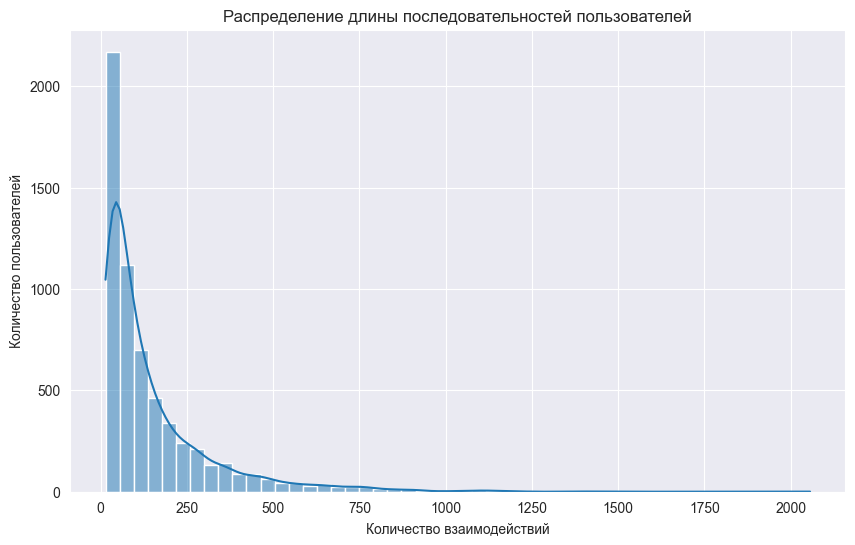

In [14]:
# Группируем по user_id и считаем количество взаимодействий
seq_lengths = interactions.groupby('user_id').size()

# Статистическая сводка
print(seq_lengths.describe())

# Визуализация распределения длины последовательностей
plt.figure(figsize=(10,6))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title('Распределение длины последовательностей пользователей')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество пользователей')
plt.show()

In [15]:
# Вычисляем процентиль, например, 90-й
max_seq_len = int(seq_lengths.quantile(0.9))
print(f"Рекомендуемая максимальная длина последовательности (90-й процентиль): {max_seq_len}")


Рекомендуемая максимальная длина последовательности (90-й процентиль): 357


In [44]:
torch.cuda.empty_cache()

In [62]:
MAX_SEQ_LEN = 200
BATCH_SIZE = 256
NUM_WORKERS = 12

model = SasRec(
    tensor_schema,
    block_count=4,
    head_count=8,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=256,
    dropout_rate=0.2,
    optimizer_factory=FatOptimizerFactory(learning_rate=0.0001),
)

csv_logger = CSVLogger(save_dir=".logs/train", name="SASRec_example")

checkpoint_callback = ModelCheckpoint(
    dirpath=".checkpoints_exp1",
    save_top_k=1,
    verbose=True,
    # if you use multiple dataloaders, then add the serial number of the dataloader to the suffix of the metric name.
    # For example,"recall@10/dataloader_idx_0"
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20],
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)]
)

trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

train_dataloader = DataLoader(
    dataset=SasRecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    persistent_workers=True,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

validation_dataloader = DataLoader(
    dataset=SasRecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    persistent_workers=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
)                                      

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\misha\Documents\PyProj\Recsys_2_new\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\misha\Documents\PyProj\Recsys_2_new\.checkpoints_exp1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | _model | SasRecModel      | 2.6 M  | train
1 | _loss  | CrossEntropyLoss | 0      | train
----------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.335    Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\misha\Documents\PyProj\Recsys_2_new\.venv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 24: 'recall@10' reached 0.01772 (best 0.01772), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=0-step=24.ckpt' as top 1


k              1        10        20         5
map     0.003311  0.006085  0.007264  0.004749
ndcg    0.003311  0.008710  0.012989  0.005456
recall  0.003311  0.017715  0.034603  0.007616



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 48: 'recall@10' reached 0.02583 (best 0.02583), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=1-step=48.ckpt' as top 1


k              1        10        20         5
map     0.002815  0.007982  0.009283  0.006551
ndcg    0.002815  0.012078  0.016838  0.008508
recall  0.002815  0.025828  0.044702  0.014570



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 72: 'recall@10' reached 0.02848 (best 0.02848), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=2-step=72.ckpt' as top 1


k              1        10        20         5
map     0.003311  0.009215  0.011235  0.007541
ndcg    0.003311  0.013652  0.021233  0.009557
recall  0.003311  0.028477  0.058940  0.015728



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 96: 'recall@10' reached 0.03361 (best 0.03361), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=3-step=96.ckpt' as top 1


k              1        10        20         5
map     0.003311  0.010057  0.012343  0.008074
ndcg    0.003311  0.015452  0.023837  0.010481
recall  0.003311  0.033609  0.066887  0.017881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 120: 'recall@10' reached 0.03543 (best 0.03543), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=4-step=120.ckpt' as top 1


k              1        10        20         5
map     0.003642  0.010372  0.012548  0.008044
ndcg    0.003642  0.016096  0.024262  0.010371
recall  0.003642  0.035430  0.068212  0.017550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 144: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003974  0.010696  0.012805  0.008422
ndcg    0.003974  0.016242  0.024159  0.010698
recall  0.003974  0.034934  0.066722  0.017715



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 168: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003477  0.010228  0.012449  0.008005
ndcg    0.003477  0.015773  0.024022  0.010344
recall  0.003477  0.034437  0.067384  0.017550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 192: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003146  0.010169  0.012144  0.007906
ndcg    0.003146  0.015876  0.023240  0.010312
recall  0.003146  0.035099  0.064570  0.017715



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 216: 'recall@10' reached 0.03858 (best 0.03858), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=8-step=216.ckpt' as top 1


k              1        10        20         5
map     0.003974  0.011782  0.014014  0.009655
ndcg    0.003974  0.017953  0.026131  0.012681
recall  0.003974  0.038576  0.071026  0.022020



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 240: 'recall@10' reached 0.04636 (best 0.04636), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=9-step=240.ckpt' as top 1


k              1        10        20         5
map     0.004801  0.014155  0.016658  0.011371
ndcg    0.004801  0.021549  0.030698  0.014677
recall  0.004801  0.046358  0.082616  0.024834



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 264: 'recall@10' reached 0.05381 (best 0.05381), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=10-step=264.ckpt' as top 1


k              1        10        20         5
map     0.004801  0.015955  0.018614  0.012649
ndcg    0.004801  0.024659  0.034581  0.016572
recall  0.004801  0.053808  0.093543  0.028642



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 288: 'recall@10' reached 0.05579 (best 0.05579), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=11-step=288.ckpt' as top 1


k              1        10        20         5
map     0.005629  0.017559  0.020512  0.014161
ndcg    0.005629  0.026380  0.037273  0.018140
recall  0.005629  0.055795  0.099172  0.030298



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 312: 'recall@10' reached 0.05894 (best 0.05894), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=12-step=312.ckpt' as top 1


k              1        10        20         5
map     0.009437  0.021153  0.024237  0.018143
ndcg    0.009437  0.029879  0.041351  0.022467
recall  0.009437  0.058940  0.104801  0.035762



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 336: 'recall@10' reached 0.06391 (best 0.06391), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=13-step=336.ckpt' as top 1


k              1        10        20         5
map     0.010762  0.022402  0.025601  0.018695
ndcg    0.010762  0.031896  0.043816  0.022688
recall  0.010762  0.063907  0.111589  0.034934



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 360: 'recall@10' reached 0.07467 (best 0.07467), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=14-step=360.ckpt' as top 1


k              1        10        20         5
map     0.013907  0.027125  0.031020  0.022919
ndcg    0.013907  0.037997  0.052379  0.027565
recall  0.013907  0.074669  0.131954  0.041887



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 384: 'recall@10' reached 0.08245 (best 0.08245), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=15-step=384.ckpt' as top 1


k             1        10        20         5
map     0.01606  0.031043  0.034972  0.026554
ndcg    0.01606  0.042844  0.057273  0.031816
recall  0.01606  0.082450  0.139735  0.048013



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 408: 'recall@10' reached 0.09255 (best 0.09255), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=16-step=408.ckpt' as top 1


k              1        10        20         5
map     0.017384  0.035372  0.039696  0.030767
ndcg    0.017384  0.048584  0.064384  0.037250
recall  0.017384  0.092550  0.155132  0.057119



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 432: 'recall@10' reached 0.10083 (best 0.10083), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=17-step=432.ckpt' as top 1


k              1        10        20         5
map     0.018709  0.037814  0.042209  0.032693
ndcg    0.018709  0.052320  0.068429  0.039591
recall  0.018709  0.100828  0.164735  0.060762



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 456: 'recall@10' reached 0.10944 (best 0.10944), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=18-step=456.ckpt' as top 1


k              1        10        20         5
map     0.019536  0.040408  0.044774  0.034506
ndcg    0.019536  0.056292  0.072391  0.041743
recall  0.019536  0.109437  0.173510  0.063907



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 480: 'recall@10' reached 0.11490 (best 0.11490), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=19-step=480.ckpt' as top 1


k              1        10        20         5
map     0.021689  0.043058  0.047642  0.036714
ndcg    0.021689  0.059572  0.076353  0.044014
recall  0.021689  0.114901  0.181457  0.066391



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 504: 'recall@10' reached 0.12086 (best 0.12086), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=20-step=504.ckpt' as top 1


k              1        10        20         5
map     0.021358  0.044178  0.048697  0.037624
ndcg    0.021358  0.061821  0.078388  0.045742
recall  0.021358  0.120861  0.186589  0.070695



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 528: 'recall@10' reached 0.12517 (best 0.12517), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=21-step=528.ckpt' as top 1


k              1        10        20         5
map     0.021192  0.045285  0.050144  0.038681
ndcg    0.021192  0.063694  0.081455  0.047437
recall  0.021192  0.125166  0.195530  0.074338



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 552: 'recall@10' reached 0.13063 (best 0.13063), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=22-step=552.ckpt' as top 1


k              1        10        20         5
map     0.022517  0.048195  0.053428  0.041744
ndcg    0.022517  0.067259  0.086337  0.051377
recall  0.022517  0.130629  0.206126  0.080960



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 576: 'recall@10' reached 0.13758 (best 0.13758), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=23-step=576.ckpt' as top 1


k              1        10        20         5
map     0.024834  0.051118  0.056364  0.044227
ndcg    0.024834  0.071075  0.090336  0.054090
recall  0.024834  0.137583  0.214073  0.084437



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 600: 'recall@10' reached 0.14371 (best 0.14371), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=24-step=600.ckpt' as top 1


k              1        10        20         5
map     0.025662  0.053812  0.059319  0.046805
ndcg    0.025662  0.074616  0.094918  0.057391
recall  0.025662  0.143709  0.224503  0.089901



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 624: 'recall@10' reached 0.15033 (best 0.15033), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=25-step=624.ckpt' as top 1


k              1        10        20         5
map     0.026987  0.056066  0.061610  0.048482
ndcg    0.026987  0.077848  0.098389  0.059227
recall  0.026987  0.150331  0.232285  0.092219



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 648: 'recall@10' reached 0.15348 (best 0.15348), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=26-step=648.ckpt' as top 1


k              1        10        20         5
map     0.028974  0.058486  0.064352  0.050704
ndcg    0.028974  0.080452  0.102055  0.061447
recall  0.028974  0.153477  0.239404  0.094371



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 672: 'recall@10' reached 0.15993 (best 0.15993), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=27-step=672.ckpt' as top 1


k              1        10        20         5
map     0.027815  0.059391  0.065240  0.051722
ndcg    0.027815  0.082661  0.104324  0.063738
recall  0.027815  0.159934  0.246358  0.100662



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 696: 'recall@10' reached 0.16440 (best 0.16440), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=28-step=696.ckpt' as top 1


k              1        10        20         5
map     0.027815  0.061223  0.067203  0.053419
ndcg    0.027815  0.085153  0.107094  0.065905
recall  0.027815  0.164404  0.251490  0.104139



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 720: 'recall@10' reached 0.17434 (best 0.17434), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=29-step=720.ckpt' as top 1


k              1        10        20         5
map     0.029305  0.064006  0.069851  0.055403
ndcg    0.029305  0.089517  0.111208  0.068242
recall  0.029305  0.174338  0.260927  0.107616



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 744: 'recall@10' reached 0.17632 (best 0.17632), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=30-step=744.ckpt' as top 1


k              1        10        20         5
map     0.028642  0.064931  0.071159  0.056145
ndcg    0.028642  0.090796  0.113705  0.069403
recall  0.028642  0.176325  0.267384  0.109934



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 768: 'recall@10' reached 0.17682 (best 0.17682), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=31-step=768.ckpt' as top 1


k              1        10        20         5
map     0.028477  0.065319  0.071966  0.056799
ndcg    0.028477  0.091271  0.115667  0.070615
recall  0.028477  0.176821  0.273676  0.112914



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 792: 'recall@10' reached 0.18228 (best 0.18228), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=32-step=792.ckpt' as top 1


k              1        10        20         5
map     0.029636  0.067663  0.074295  0.058488
ndcg    0.029636  0.094362  0.118739  0.072358
recall  0.029636  0.182285  0.279139  0.114735



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 816: 'recall@10' reached 0.18825 (best 0.18825), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=33-step=816.ckpt' as top 1


k              1        10        20         5
map     0.032119  0.071138  0.077940  0.062321
ndcg    0.032119  0.098374  0.123563  0.076793
recall  0.032119  0.188245  0.288742  0.121026



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 840: 'recall@10' reached 0.18974 (best 0.18974), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=34-step=840.ckpt' as top 1


k              1        10        20         5
map     0.031291  0.071530  0.078645  0.062445
ndcg    0.031291  0.099090  0.125334  0.077082
recall  0.031291  0.189735  0.294205  0.121689



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 864: 'recall@10' reached 0.19404 (best 0.19404), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=35-step=864.ckpt' as top 1


k             1        10        20         5
map     0.03245  0.073134  0.080300  0.063913
ndcg    0.03245  0.101304  0.127638  0.078973
recall  0.03245  0.194040  0.298676  0.125000



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 888: 'recall@10' reached 0.19834 (best 0.19834), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=36-step=888.ckpt' as top 1


k             1        10        20         5
map     0.03394  0.075161  0.082441  0.065706
ndcg    0.03394  0.103829  0.130667  0.080856
recall  0.03394  0.198344  0.305132  0.127152



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 912: 'recall@10' reached 0.20298 (best 0.20298), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=37-step=912.ckpt' as top 1


k              1        10        20         5
map     0.035927  0.077093  0.084499  0.067105
ndcg    0.035927  0.106336  0.133661  0.082074
recall  0.035927  0.202980  0.311755  0.127815



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 936: 'recall@10' reached 0.20762 (best 0.20762), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=38-step=936.ckpt' as top 1


k              1        10        20         5
map     0.037086  0.078931  0.086440  0.068860
ndcg    0.037086  0.108777  0.136258  0.084121
recall  0.037086  0.207616  0.316556  0.130795



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 960: 'recall@10' reached 0.21026 (best 0.21026), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=39-step=960.ckpt' as top 1


k              1        10        20         5
map     0.036258  0.079065  0.086643  0.068714
ndcg    0.036258  0.109461  0.137168  0.083927
recall  0.036258  0.210265  0.320033  0.130298



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 984: 'recall@10' reached 0.21490 (best 0.21490), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=40-step=984.ckpt' as top 1


k              1        10        20         5
map     0.036921  0.080727  0.088348  0.070052
ndcg    0.036921  0.111813  0.139764  0.085545
recall  0.036921  0.214901  0.325828  0.132781



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 1008: 'recall@10' reached 0.21738 (best 0.21738), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=41-step=1008.ckpt' as top 1


k              1        10        20         5
map     0.039735  0.082524  0.090172  0.071283
ndcg    0.039735  0.113741  0.141893  0.086434
recall  0.039735  0.217384  0.329305  0.132781



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 1032: 'recall@10' reached 0.22020 (best 0.22020), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=42-step=1032.ckpt' as top 1


k              1        10        20         5
map     0.040066  0.083986  0.091760  0.073278
ndcg    0.040066  0.115577  0.143937  0.089431
recall  0.040066  0.220199  0.332450  0.138907



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 1056: 'recall@10' reached 0.22318 (best 0.22318), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=43-step=1056.ckpt' as top 1


k              1        10        20         5
map     0.040232  0.084611  0.092458  0.073557
ndcg    0.040232  0.116712  0.145600  0.089655
recall  0.040232  0.223179  0.338079  0.138907



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 1080: 'recall@10' reached 0.22815 (best 0.22815), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=44-step=1080.ckpt' as top 1


k             1        10        20         5
map     0.03957  0.085771  0.093553  0.074567
ndcg    0.03957  0.118780  0.147423  0.091322
recall  0.03957  0.228146  0.342053  0.142550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 1104: 'recall@10' reached 0.22914 (best 0.22914), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=45-step=1104.ckpt' as top 1


k              1        10        20         5
map     0.039901  0.086618  0.094610  0.075378
ndcg    0.039901  0.119730  0.149105  0.092424
recall  0.039901  0.229139  0.345861  0.144536



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 1128: 'recall@10' reached 0.23113 (best 0.23113), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=46-step=1128.ckpt' as top 1


k              1        10        20         5
map     0.041391  0.088069  0.096079  0.076852
ndcg    0.041391  0.121297  0.150832  0.093984
recall  0.041391  0.231126  0.348675  0.146358



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 1152: 'recall@10' reached 0.23477 (best 0.23477), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=47-step=1152.ckpt' as top 1


k             1        10        20         5
map     0.04106  0.088998  0.096934  0.077610
ndcg    0.04106  0.122856  0.152187  0.095029
recall  0.04106  0.234768  0.351656  0.148179



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 1176: 'recall@10' reached 0.23692 (best 0.23692), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=48-step=1176.ckpt' as top 1


k              1        10        20         5
map     0.042219  0.090291  0.098261  0.078819
ndcg    0.042219  0.124335  0.153766  0.096326
recall  0.042219  0.236921  0.354139  0.149834



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 1200: 'recall@10' reached 0.23907 (best 0.23907), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=49-step=1200.ckpt' as top 1


k              1        10        20         5
map     0.041225  0.090335  0.098260  0.078772
ndcg    0.041225  0.124904  0.154197  0.096711
recall  0.041225  0.239073  0.355795  0.151490



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 1224: 'recall@10' was not in top 1


k              1        10        20         5
map     0.042881  0.091702  0.099698  0.080041
ndcg    0.042881  0.125957  0.155367  0.097570
recall  0.042881  0.239073  0.355960  0.150993



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 1248: 'recall@10' reached 0.24288 (best 0.24288), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=51-step=1248.ckpt' as top 1


k              1        10        20         5
map     0.041391  0.091839  0.099755  0.080254
ndcg    0.041391  0.126953  0.156097  0.098580
recall  0.041391  0.242881  0.358775  0.154470



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 1272: 'recall@10' reached 0.24404 (best 0.24404), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=52-step=1272.ckpt' as top 1


k              1        10        20         5
map     0.043046  0.093113  0.101111  0.081518
ndcg    0.043046  0.128189  0.157604  0.099806
recall  0.043046  0.244040  0.360927  0.155629



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 1296: 'recall@10' was not in top 1


k              1        10        20         5
map     0.042053  0.092466  0.100536  0.081071
ndcg    0.042053  0.127694  0.157420  0.099885
recall  0.042053  0.243874  0.362086  0.157450



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 1320: 'recall@10' reached 0.24801 (best 0.24801), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=54-step=1320.ckpt' as top 1


k              1        10        20         5
map     0.044371  0.094715  0.102727  0.082401
ndcg    0.044371  0.130324  0.159699  0.100433
recall  0.044371  0.248013  0.364570  0.155464



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 1344: 'recall@10' was not in top 1


k              1        10        20         5
map     0.044702  0.095556  0.103758  0.083910
ndcg    0.044702  0.131036  0.161092  0.102662
recall  0.044702  0.248013  0.367219  0.159934



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 1368: 'recall@10' reached 0.25199 (best 0.25199), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=56-step=1368.ckpt' as top 1


k              1        10        20         5
map     0.043874  0.096068  0.104186  0.084189
ndcg    0.043874  0.132372  0.162240  0.103515
recall  0.043874  0.251987  0.370695  0.162583



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 1392: 'recall@10' reached 0.25480 (best 0.25480), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=57-step=1392.ckpt' as top 1


k              1        10        20         5
map     0.044536  0.096683  0.104596  0.084415
ndcg    0.044536  0.133400  0.162514  0.103372
recall  0.044536  0.254801  0.370530  0.161258



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 1416: 'recall@10' was not in top 1


k             1        10        20         5
map     0.04404  0.097232  0.105480  0.085292
ndcg    0.04404  0.133804  0.164106  0.104667
recall  0.04404  0.254305  0.374669  0.163742



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 1440: 'recall@10' reached 0.25613 (best 0.25613), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=59-step=1440.ckpt' as top 1


k              1        10        20         5
map     0.045861  0.098089  0.106349  0.085546
ndcg    0.045861  0.134826  0.165279  0.104390
recall  0.045861  0.256126  0.377318  0.161921



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 1464: 'recall@10' reached 0.25811 (best 0.25811), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=60-step=1464.ckpt' as top 1


k              1        10        20         5
map     0.045364  0.098532  0.106825  0.086374
ndcg    0.045364  0.135689  0.166293  0.106108
recall  0.045364  0.258113  0.379967  0.166391



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 1488: 'recall@10' reached 0.25861 (best 0.25861), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=61-step=1488.ckpt' as top 1


k              1        10        20         5
map     0.047517  0.099761  0.107965  0.087376
ndcg    0.047517  0.136670  0.166943  0.106521
recall  0.047517  0.258609  0.379139  0.165066



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 1512: 'recall@10' reached 0.26209 (best 0.26209), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=62-step=1512.ckpt' as top 1


k              1        10        20         5
map     0.046026  0.099427  0.107518  0.086788
ndcg    0.046026  0.137221  0.167160  0.106410
recall  0.046026  0.262086  0.381457  0.166391



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 1536: 'recall@10' reached 0.26242 (best 0.26242), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=63-step=1536.ckpt' as top 1


k              1        10        20         5
map     0.047517  0.100331  0.108394  0.087724
ndcg    0.047517  0.138000  0.167604  0.107376
recall  0.047517  0.262417  0.379967  0.167550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 1560: 'recall@10' reached 0.26374 (best 0.26374), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=64-step=1560.ckpt' as top 1


k              1        10        20         5
map     0.047682  0.100836  0.109073  0.087809
ndcg    0.047682  0.138677  0.169016  0.107096
recall  0.047682  0.263742  0.384437  0.166060



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 1584: 'recall@10' reached 0.26772 (best 0.26772), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=65-step=1584.ckpt' as top 1


k              1        10        20         5
map     0.047682  0.101580  0.109605  0.088491
ndcg    0.047682  0.140143  0.169777  0.108250
recall  0.047682  0.267715  0.385762  0.168709



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 1608: 'recall@10' was not in top 1


k              1        10        20         5
map     0.047185  0.101700  0.110057  0.088722
ndcg    0.047185  0.139975  0.170712  0.108257
recall  0.047185  0.266556  0.388742  0.167881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 1632: 'recall@10' was not in top 1


k              1        10        20         5
map     0.050828  0.103368  0.111732  0.090428
ndcg    0.050828  0.141167  0.171832  0.109735
recall  0.050828  0.266225  0.387914  0.168874



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 1656: 'recall@10' reached 0.27003 (best 0.27003), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=68-step=1656.ckpt' as top 1


k              1        10        20         5
map     0.049503  0.104321  0.112697  0.091371
ndcg    0.049503  0.142821  0.173662  0.111225
recall  0.049503  0.270033  0.392715  0.171854



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 1680: 'recall@10' reached 0.27086 (best 0.27086), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=69-step=1680.ckpt' as top 1


k              1        10        20         5
map     0.049503  0.104284  0.112569  0.091305
ndcg    0.049503  0.142962  0.173668  0.111278
recall  0.049503  0.270861  0.393377  0.172351



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 1704: 'recall@10' was not in top 1


k              1        10        20         5
map     0.049503  0.103915  0.112428  0.090977
ndcg    0.049503  0.142564  0.174021  0.111009
recall  0.049503  0.270364  0.395695  0.172351



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 1728: 'recall@10' reached 0.27136 (best 0.27136), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=71-step=1728.ckpt' as top 1


k              1        10        20         5
map     0.050662  0.104774  0.113101  0.091656
ndcg    0.050662  0.143430  0.174246  0.111479
recall  0.050662  0.271358  0.394205  0.172185



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 1752: 'recall@10' reached 0.27202 (best 0.27202), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=72-step=1752.ckpt' as top 1


k              1        10        20         5
map     0.050497  0.105004  0.113551  0.092092
ndcg    0.050497  0.143794  0.175432  0.112331
recall  0.050497  0.272020  0.398179  0.174338



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 1776: 'recall@10' reached 0.27301 (best 0.27301), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=73-step=1776.ckpt' as top 1


k              1        10        20         5
map     0.051159  0.105723  0.114155  0.092621
ndcg    0.051159  0.144568  0.175708  0.112600
recall  0.051159  0.273013  0.397020  0.173675



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 1800: 'recall@10' reached 0.27318 (best 0.27318), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=74-step=1800.ckpt' as top 1


k              1        10        20         5
map     0.052318  0.106912  0.115449  0.094412
ndcg    0.052318  0.145579  0.176962  0.115123
recall  0.052318  0.273179  0.397848  0.178642



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 1824: 'recall@10' was not in top 1


k          1        10        20         5
map     0.05  0.104964  0.113651  0.092318
ndcg    0.05  0.143969  0.175950  0.113088
recall  0.05  0.272848  0.400000  0.176821



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 1848: 'recall@10' reached 0.27351 (best 0.27351), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=76-step=1848.ckpt' as top 1


k              1        10        20         5
map     0.050166  0.105737  0.114378  0.092947
ndcg    0.050166  0.144739  0.176551  0.113528
recall  0.050166  0.273510  0.400000  0.176490



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 1872: 'recall@10' reached 0.27517 (best 0.27517), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=77-step=1872.ckpt' as top 1


k              1        10        20         5
map     0.049669  0.105339  0.113881  0.092332
ndcg    0.049669  0.144802  0.176246  0.113090
recall  0.049669  0.275166  0.400166  0.176656



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 1896: 'recall@10' reached 0.27583 (best 0.27583), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=78-step=1896.ckpt' as top 1


k              1        10        20         5
map     0.051325  0.106593  0.115144  0.093800
ndcg    0.051325  0.145884  0.177500  0.114542
recall  0.051325  0.275828  0.401821  0.178146



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 1920: 'recall@10' was not in top 1


k              1        10        20         5
map     0.049503  0.105707  0.114466  0.093091
ndcg    0.049503  0.144965  0.177116  0.114239
recall  0.049503  0.274338  0.401987  0.178974



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 1944: 'recall@10' reached 0.27864 (best 0.27864), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=80-step=1944.ckpt' as top 1


k              1        10        20         5
map     0.049669  0.105828  0.114428  0.092503
ndcg    0.049669  0.145950  0.177683  0.113384
recall  0.049669  0.278642  0.404967  0.177318



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 1968: 'recall@10' was not in top 1


k              1        10        20         5
map     0.049338  0.106532  0.115325  0.094186
ndcg    0.049338  0.146187  0.178493  0.116017
recall  0.049338  0.276821  0.405132  0.182947



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 1992: 'recall@10' reached 0.28146 (best 0.28146), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=82-step=1992.ckpt' as top 1


k              1        10        20         5
map     0.049834  0.107763  0.116492  0.095364
ndcg    0.049834  0.148174  0.180422  0.117604
recall  0.049834  0.281457  0.409934  0.185762



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 2016: 'recall@10' was not in top 1


k              1        10        20         5
map     0.050828  0.107472  0.116136  0.094365
ndcg    0.050828  0.147525  0.179393  0.115492
recall  0.050828  0.279801  0.406457  0.180132



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 2040: 'recall@10' was not in top 1


k              1        10        20         5
map     0.050828  0.107333  0.116143  0.094109
ndcg    0.050828  0.147499  0.179798  0.115283
recall  0.050828  0.280132  0.408278  0.180132



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 2064: 'recall@10' reached 0.28228 (best 0.28228), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=85-step=2064.ckpt' as top 1


k             1        10        20         5
map     0.05149  0.108141  0.116869  0.095039
ndcg    0.05149  0.148599  0.180655  0.116539
recall  0.05149  0.282285  0.409603  0.182450



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 2088: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051159  0.107996  0.116941  0.095315
ndcg    0.051159  0.147956  0.180670  0.116881
recall  0.051159  0.279801  0.409437  0.182947



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 2112: 'recall@10' reached 0.28328 (best 0.28328), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=87-step=2112.ckpt' as top 1


k              1        10        20         5
map     0.051656  0.108629  0.117346  0.095808
ndcg    0.051656  0.149195  0.181266  0.117668
recall  0.051656  0.283278  0.410762  0.184768



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 2136: 'recall@10' reached 0.28460 (best 0.28460), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=88-step=2136.ckpt' as top 1


k              1        10        20         5
map     0.051325  0.109023  0.117728  0.096421
ndcg    0.051325  0.149845  0.181734  0.118852
recall  0.051325  0.284603  0.411093  0.187748



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 2160: 'recall@10' reached 0.28510 (best 0.28510), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=89-step=2160.ckpt' as top 1


k              1        10        20         5
map     0.051821  0.109524  0.118194  0.096722
ndcg    0.051821  0.150342  0.182300  0.118866
recall  0.051821  0.285099  0.412252  0.186755



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 2184: 'recall@10' was not in top 1


k              1        10        20         5
map     0.052318  0.109525  0.118570  0.097042
ndcg    0.052318  0.149311  0.182397  0.118877
recall  0.052318  0.280298  0.411424  0.185762



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 2208: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051325  0.109204  0.117978  0.096606
ndcg    0.051325  0.149849  0.181940  0.118985
recall  0.051325  0.283775  0.410927  0.187583



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 2232: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051325  0.109500  0.118366  0.096336
ndcg    0.051325  0.150231  0.182841  0.118045
recall  0.051325  0.284603  0.414238  0.184437



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 2256: 'recall@10' reached 0.28742 (best 0.28742), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=93-step=2256.ckpt' as top 1


k              1        10        20         5
map     0.052815  0.110877  0.119721  0.098066
ndcg    0.052815  0.151918  0.184311  0.120335
recall  0.052815  0.287417  0.415894  0.188576



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 2280: 'recall@10' was not in top 1


k              1        10        20         5
map     0.052483  0.110554  0.119266  0.097812
ndcg    0.052483  0.151469  0.183370  0.120243
recall  0.052483  0.286424  0.412914  0.189073



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 2304: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051325  0.110127  0.119002  0.097086
ndcg    0.051325  0.150981  0.183442  0.119139
recall  0.051325  0.285596  0.414238  0.186589



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 2328: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053642  0.112102  0.121013  0.099454
ndcg    0.053642  0.152652  0.185130  0.121608
recall  0.053642  0.286258  0.414735  0.189404



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 2352: 'recall@10' reached 0.28924 (best 0.28924), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=97-step=2352.ckpt' as top 1


k              1        10        20         5
map     0.051821  0.110968  0.119681  0.097867
ndcg    0.051821  0.152436  0.184393  0.120315
recall  0.051821  0.289238  0.416060  0.189073



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 2376: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051656  0.110585  0.119503  0.097508
ndcg    0.051656  0.151528  0.184237  0.119620
recall  0.051656  0.286424  0.416225  0.187252



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 2400: 'recall@10' was not in top 1


k              1        10        20         5
map     0.052483  0.110966  0.119889  0.097787
ndcg    0.052483  0.151911  0.184350  0.119805
recall  0.052483  0.286921  0.415066  0.187252



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100, global step 2424: 'recall@10' was not in top 1


k              1        10        20         5
map     0.052815  0.111285  0.120224  0.098532
ndcg    0.052815  0.152260  0.184828  0.120987
recall  0.052815  0.287252  0.416060  0.189735



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101, global step 2448: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053311  0.111641  0.120738  0.098634
ndcg    0.053311  0.152631  0.185890  0.120856
recall  0.053311  0.287748  0.419536  0.188907



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102, global step 2472: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053974  0.112030  0.121098  0.098996
ndcg    0.053974  0.152780  0.185896  0.121038
recall  0.053974  0.287086  0.418212  0.188576



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 2496: 'recall@10' was not in top 1


k              1        10        20         5
map     0.052152  0.111501  0.120430  0.098538
ndcg    0.052152  0.152788  0.185452  0.121085
recall  0.052152  0.288742  0.418212  0.190066



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104, global step 2520: 'recall@10' reached 0.29023 (best 0.29023), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=104-step=2520.ckpt' as top 1


k              1        10        20         5
map     0.051987  0.111682  0.120538  0.098565
ndcg    0.051987  0.153258  0.185554  0.121152
recall  0.051987  0.290232  0.418046  0.190232



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105, global step 2544: 'recall@10' was not in top 1


k              1        10        20         5
map     0.050331  0.110700  0.119852  0.098057
ndcg    0.050331  0.152231  0.185670  0.121323
recall  0.050331  0.288742  0.421192  0.192550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106, global step 2568: 'recall@10' was not in top 1


k              1        10        20         5
map     0.051325  0.111430  0.120739  0.098717
ndcg    0.051325  0.152550  0.186458  0.121533
recall  0.051325  0.287583  0.421689  0.191225



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 2592: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053146  0.112303  0.121325  0.099385
ndcg    0.053146  0.153583  0.186559  0.121926
recall  0.053146  0.289570  0.420199  0.190894



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108, global step 2616: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053146  0.112652  0.122075  0.099779
ndcg    0.053146  0.153379  0.187732  0.122236
recall  0.053146  0.287086  0.423013  0.190894



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 2640: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053808  0.113380  0.122452  0.100491
ndcg    0.053808  0.154564  0.187711  0.123123
recall  0.053808  0.290066  0.421358  0.192384



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110, global step 2664: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05298  0.113434  0.122734  0.100695
ndcg    0.05298  0.154617  0.188815  0.123580
recall  0.05298  0.289901  0.425828  0.193543



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111, global step 2688: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054305  0.113293  0.122645  0.100262
ndcg    0.054305  0.153991  0.188094  0.122250
recall  0.054305  0.287914  0.422848  0.189404



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112, global step 2712: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053311  0.112907  0.122538  0.100414
ndcg    0.053311  0.153464  0.188522  0.123113
recall  0.053311  0.286589  0.425166  0.192550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113, global step 2736: 'recall@10' reached 0.29255 (best 0.29255), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=113-step=2736.ckpt' as top 1


k              1        10        20         5
map     0.055795  0.115592  0.124644  0.102398
ndcg    0.055795  0.156840  0.189958  0.124718
recall  0.055795  0.292550  0.423841  0.192881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114, global step 2760: 'recall@10' was not in top 1


k              1        10        20         5
map     0.053146  0.113749  0.122992  0.100762
ndcg    0.053146  0.155226  0.189026  0.123595
recall  0.053146  0.291556  0.425497  0.193377



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115, global step 2784: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05447  0.114420  0.123556  0.101446
ndcg    0.05447  0.155603  0.188911  0.123981
recall  0.05447  0.291060  0.422848  0.192881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116, global step 2808: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054636  0.114828  0.124121  0.101680
ndcg    0.054636  0.156078  0.190075  0.124094
recall  0.054636  0.291722  0.426490  0.192550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117, global step 2832: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054139  0.114276  0.123556  0.101302
ndcg    0.054139  0.155510  0.189411  0.123922
recall  0.054139  0.291060  0.425331  0.193046



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118, global step 2856: 'recall@10' reached 0.29669 (best 0.29669), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=118-step=2856.ckpt' as top 1


k              1        10        20         5
map     0.056457  0.116257  0.125161  0.102806
ndcg    0.056457  0.158235  0.190925  0.125358
recall  0.056457  0.296689  0.426490  0.194371



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119, global step 2880: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05596  0.115924  0.125149  0.102980
ndcg    0.05596  0.157350  0.191182  0.125698
recall  0.05596  0.293709  0.427980  0.195199



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120, global step 2904: 'recall@10' was not in top 1


k              1        10        20         5
map     0.055629  0.115646  0.124739  0.102276
ndcg    0.055629  0.157222  0.190588  0.124547
recall  0.055629  0.294205  0.426656  0.192550



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121, global step 2928: 'recall@10' was not in top 1


k              1        10        20         5
map     0.055132  0.115470  0.124704  0.102312
ndcg    0.055132  0.156981  0.190768  0.124929
recall  0.055132  0.293543  0.427483  0.194040



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122, global step 2952: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056788  0.116485  0.125748  0.103397
ndcg    0.056788  0.157710  0.191753  0.125787
recall  0.056788  0.293377  0.428642  0.194205



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123, global step 2976: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054801  0.115245  0.124424  0.101736
ndcg    0.054801  0.156791  0.190456  0.124005
recall  0.054801  0.293377  0.426987  0.191887



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124, global step 3000: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056623  0.116525  0.125706  0.103449
ndcg    0.056623  0.158069  0.191765  0.126098
recall  0.056623  0.294868  0.428642  0.195364



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125, global step 3024: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05596  0.116154  0.125383  0.102972
ndcg    0.05596  0.157443  0.191113  0.125238
recall  0.05596  0.293377  0.426656  0.193212



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126, global step 3048: 'recall@10' was not in top 1


k              1        10        20         5
map     0.055464  0.116162  0.125520  0.102870
ndcg    0.055464  0.157787  0.192084  0.125443
recall  0.055464  0.294702  0.430795  0.194371



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127, global step 3072: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05447  0.115495  0.124766  0.101921
ndcg    0.05447  0.157216  0.190998  0.124367
recall  0.05447  0.294371  0.427980  0.192881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128, global step 3096: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054801  0.115674  0.125060  0.102450
ndcg    0.054801  0.156974  0.191422  0.124789
recall  0.054801  0.292715  0.429470  0.192881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129, global step 3120: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057781  0.117291  0.126460  0.103747
ndcg    0.057781  0.158623  0.192248  0.125554
recall  0.057781  0.294868  0.428311  0.192053



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130, global step 3144: 'recall@10' reached 0.29735 (best 0.29735), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=130-step=3144.ckpt' as top 1


k              1        10        20         5
map     0.055464  0.116655  0.125922  0.103182
ndcg    0.055464  0.158733  0.192812  0.125797
recall  0.055464  0.297351  0.432781  0.194868



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131, global step 3168: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056788  0.116809  0.125849  0.103673
ndcg    0.056788  0.158429  0.191594  0.126241
recall  0.056788  0.295530  0.427152  0.195199



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132, global step 3192: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057119  0.117690  0.126831  0.104633
ndcg    0.057119  0.159151  0.192662  0.127263
recall  0.057119  0.295530  0.428477  0.196358



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133, global step 3216: 'recall@10' was not in top 1


k              1        10        20         5
map     0.054967  0.116076  0.125239  0.102230
ndcg    0.054967  0.158087  0.191787  0.124337
recall  0.054967  0.296523  0.430464  0.191722



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134, global step 3240: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056623  0.117665  0.126902  0.104335
ndcg    0.056623  0.159238  0.193138  0.126698
recall  0.056623  0.296026  0.430629  0.194868



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135, global step 3264: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056126  0.117302  0.126620  0.103480
ndcg    0.056126  0.159166  0.193332  0.125540
recall  0.056126  0.297020  0.432616  0.192715



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136, global step 3288: 'recall@10' reached 0.29818 (best 0.29818), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=136-step=3288.ckpt' as top 1


k              1        10        20         5
map     0.058444  0.119439  0.128730  0.105988
ndcg    0.058444  0.161107  0.195241  0.128381
recall  0.058444  0.298179  0.433775  0.196689



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137, global step 3312: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057119  0.118073  0.127257  0.104487
ndcg    0.057119  0.159593  0.193123  0.126454
recall  0.057119  0.296358  0.429139  0.193377



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138, global step 3336: 'recall@10' reached 0.29884 (best 0.29884), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=138-step=3336.ckpt' as top 1


k              1        10        20         5
map     0.056457  0.117576  0.126568  0.103609
ndcg    0.056457  0.159762  0.192888  0.125675
recall  0.056457  0.298841  0.430629  0.192881



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139, global step 3360: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05596  0.117543  0.126570  0.103816
ndcg    0.05596  0.159783  0.192763  0.126311
recall  0.05596  0.298841  0.429470  0.194868



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140, global step 3384: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057947  0.118198  0.127463  0.104630
ndcg    0.057947  0.159757  0.193586  0.126695
recall  0.057947  0.296689  0.430629  0.194040



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141, global step 3408: 'recall@10' was not in top 1


k              1        10        20         5
map     0.056954  0.118589  0.127614  0.105378
ndcg    0.056954  0.160499  0.193338  0.128202
recall  0.056954  0.298344  0.428146  0.197848



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142, global step 3432: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057781  0.118396  0.127771  0.104887
ndcg    0.057781  0.160110  0.194323  0.127136
recall  0.057781  0.297517  0.432947  0.195033



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143, global step 3456: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058444  0.119487  0.128741  0.105869
ndcg    0.058444  0.161127  0.194967  0.127983
recall  0.058444  0.298179  0.432285  0.195364



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144, global step 3480: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057285  0.118322  0.127576  0.104721
ndcg    0.057285  0.160069  0.193773  0.126943
recall  0.057285  0.297517  0.430795  0.194702



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145, global step 3504: 'recall@10' reached 0.30182 (best 0.30182), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=145-step=3504.ckpt' as top 1


k              1        10        20         5
map     0.058444  0.119149  0.128022  0.105022
ndcg    0.058444  0.161639  0.194237  0.127202
recall  0.058444  0.301821  0.431291  0.194868



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146, global step 3528: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057285  0.118316  0.127532  0.104357
ndcg    0.057285  0.160255  0.194076  0.126268
recall  0.057285  0.298510  0.432781  0.193046



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147, global step 3552: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.120511  0.129500  0.106556
ndcg    0.059437  0.162721  0.195792  0.128770
recall  0.059437  0.301821  0.433278  0.196523



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148, global step 3576: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057285  0.118947  0.128041  0.105179
ndcg    0.057285  0.160917  0.194288  0.127340
recall  0.057285  0.299172  0.431623  0.194868



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149, global step 3600: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05894  0.119788  0.128828  0.105803
ndcg    0.05894  0.161926  0.194896  0.127757
recall  0.05894  0.300993  0.431457  0.194702



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150, global step 3624: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058775  0.119225  0.128169  0.105853
ndcg    0.058775  0.161106  0.193848  0.128364
recall  0.058775  0.299172  0.428973  0.197185



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151, global step 3648: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057119  0.119494  0.128365  0.105317
ndcg    0.057119  0.161900  0.194522  0.127381
recall  0.057119  0.301656  0.431291  0.194536



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152, global step 3672: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059934  0.120646  0.129713  0.107216
ndcg    0.059934  0.162416  0.195503  0.129648
recall  0.059934  0.300000  0.430960  0.198179



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153, global step 3696: 'recall@10' reached 0.30232 (best 0.30232), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=153-step=3696.ckpt' as top 1


k              1        10        20         5
map     0.059934  0.121369  0.130399  0.107715
ndcg    0.059934  0.163496  0.196619  0.130128
recall  0.059934  0.302318  0.433775  0.198510



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154, global step 3720: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058113  0.119872  0.128819  0.106589
ndcg    0.058113  0.162013  0.194619  0.129551
recall  0.058113  0.300662  0.429636  0.199669



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155, global step 3744: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057947  0.119757  0.128770  0.105853
ndcg    0.057947  0.161990  0.194928  0.128090
recall  0.057947  0.301159  0.431623  0.195861



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156, global step 3768: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.119956  0.129160  0.105894
ndcg    0.059437  0.161710  0.195185  0.127621
recall  0.059437  0.299338  0.431623  0.193874



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157, global step 3792: 'recall@10' reached 0.30248 (best 0.30248), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=157-step=3792.ckpt' as top 1


k              1        10        20         5
map     0.059272  0.120597  0.129519  0.106647
ndcg    0.059272  0.162928  0.195617  0.128920
recall  0.059272  0.302483  0.432119  0.196854



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158, global step 3816: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058444  0.120129  0.129271  0.106490
ndcg    0.058444  0.162018  0.195306  0.128885
recall  0.058444  0.299834  0.431457  0.197185



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159, global step 3840: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059934  0.120914  0.129972  0.106885
ndcg    0.059934  0.163008  0.196029  0.128854
recall  0.059934  0.301821  0.432450  0.195861



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160, global step 3864: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05894  0.120847  0.129852  0.107083
ndcg    0.05894  0.163182  0.196028  0.129767
recall  0.05894  0.302483  0.432450  0.199007



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161, global step 3888: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060762  0.121349  0.130432  0.107461
ndcg    0.060762  0.163356  0.196710  0.129440
recall  0.060762  0.301987  0.434437  0.196523



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162, global step 3912: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057947  0.119852  0.128799  0.106272
ndcg    0.057947  0.162058  0.194747  0.128916
recall  0.057947  0.300993  0.430464  0.198013



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163, global step 3936: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057781  0.119155  0.128211  0.105414
ndcg    0.057781  0.161334  0.194266  0.127781
recall  0.057781  0.300331  0.430464  0.196026



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164, global step 3960: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058775  0.120332  0.129336  0.106857
ndcg    0.058775  0.162131  0.194920  0.129253
recall  0.058775  0.299669  0.429305  0.197517



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165, global step 3984: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.121181  0.130157  0.107437
ndcg    0.059437  0.163386  0.196278  0.129958
recall  0.059437  0.302318  0.432781  0.198675



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166, global step 4008: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060927  0.121431  0.130624  0.107897
ndcg    0.060927  0.163172  0.196692  0.130270
recall  0.060927  0.300662  0.433278  0.198675



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167, global step 4032: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058775  0.120552  0.129630  0.107067
ndcg    0.058775  0.162419  0.195493  0.129567
recall  0.058775  0.300166  0.430960  0.198179



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168, global step 4056: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059603  0.120631  0.129614  0.106559
ndcg    0.059603  0.162675  0.195326  0.128450
recall  0.059603  0.301325  0.430298  0.195199



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169, global step 4080: 'recall@10' reached 0.30364 (best 0.30364), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=169-step=4080.ckpt' as top 1


k              1        10        20         5
map     0.061424  0.122872  0.132005  0.109192
ndcg    0.061424  0.164952  0.198395  0.131497
recall  0.061424  0.303642  0.436258  0.199503



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170, global step 4104: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.120789  0.129840  0.106600
ndcg    0.059437  0.162999  0.195900  0.128497
recall  0.059437  0.302152  0.432119  0.195199



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171, global step 4128: 'recall@10' reached 0.30497 (best 0.30497), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=171-step=4128.ckpt' as top 1


k              1        10        20         5
map     0.059768  0.121827  0.130774  0.107812
ndcg    0.059768  0.164428  0.197173  0.130164
recall  0.059768  0.304967  0.434768  0.198344



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172, global step 4152: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060265  0.121519  0.130597  0.107547
ndcg    0.060265  0.163605  0.196787  0.129633
recall  0.060265  0.302318  0.433775  0.197020



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173, global step 4176: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059934  0.121601  0.130648  0.107602
ndcg    0.059934  0.163976  0.196980  0.129853
recall  0.059934  0.303642  0.434272  0.197682



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174, global step 4200: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060762  0.121472  0.130716  0.107580
ndcg    0.060762  0.163376  0.197039  0.129610
recall  0.060762  0.301490  0.434603  0.196854



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175, global step 4224: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061093  0.122676  0.131771  0.108720
ndcg    0.061093  0.164658  0.197918  0.130672
recall  0.061093  0.302980  0.434768  0.197517



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176, global step 4248: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061424  0.122473  0.131492  0.108245
ndcg    0.061424  0.164420  0.197090  0.129906
recall  0.061424  0.302649  0.431457  0.195861



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177, global step 4272: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061258  0.121916  0.131258  0.108102
ndcg    0.061258  0.163473  0.197341  0.129753
recall  0.061258  0.300497  0.434106  0.195695



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178, global step 4296: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060099  0.121232  0.130469  0.107310
ndcg    0.060099  0.163142  0.196659  0.129282
recall  0.060099  0.301159  0.433444  0.196192



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179, global step 4320: 'recall@10' was not in top 1


k              1        10        20         5
map     0.063245  0.123563  0.132599  0.109754
ndcg    0.063245  0.165335  0.198350  0.131619
recall  0.063245  0.303146  0.433940  0.198344



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180, global step 4344: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061093  0.121624  0.130921  0.108049
ndcg    0.061093  0.163682  0.197739  0.130516
recall  0.061093  0.302318  0.437417  0.199172



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181, global step 4368: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061424  0.121591  0.130986  0.107958
ndcg    0.061424  0.163499  0.197733  0.130243
recall  0.061424  0.301656  0.437086  0.198344



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182, global step 4392: 'recall@10' reached 0.30613 (best 0.30613), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=182-step=4392.ckpt' as top 1


k             1        10        20         5
map     0.06043  0.121738  0.130633  0.107776
ndcg    0.06043  0.164601  0.197170  0.130328
recall  0.06043  0.306126  0.435265  0.199172



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183, global step 4416: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060762  0.121668  0.130796  0.107867
ndcg    0.060762  0.164049  0.197375  0.130315
recall  0.060762  0.303808  0.435762  0.198841



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184, global step 4440: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060596  0.121750  0.130872  0.107403
ndcg    0.060596  0.164282  0.197768  0.129401
recall  0.060596  0.304636  0.437583  0.196523



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185, global step 4464: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060596  0.122562  0.131458  0.108940
ndcg    0.060596  0.164991  0.197368  0.131621
recall  0.060596  0.304801  0.432781  0.200828



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186, global step 4488: 'recall@10' was not in top 1


k             1        10        20         5
map     0.06043  0.122252  0.131388  0.108488
ndcg    0.06043  0.164727  0.198119  0.131123
recall  0.06043  0.304636  0.436921  0.200166



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187, global step 4512: 'recall@10' was not in top 1


k              1        10        20         5
map     0.062252  0.122708  0.131696  0.108943
ndcg    0.062252  0.165094  0.197944  0.131457
recall  0.062252  0.304967  0.435099  0.200331



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188, global step 4536: 'recall@10' was not in top 1


k             1        10        20         5
map     0.06043  0.122655  0.131585  0.108474
ndcg    0.06043  0.165275  0.197941  0.130652
recall  0.06043  0.305795  0.435265  0.198179



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189, global step 4560: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060596  0.121724  0.130618  0.107478
ndcg    0.060596  0.164447  0.196929  0.129543
recall  0.060596  0.305629  0.434272  0.196854



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190, global step 4584: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061258  0.122107  0.131157  0.108171
ndcg    0.061258  0.164470  0.197477  0.130408
recall  0.061258  0.304305  0.434934  0.198344



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191, global step 4608: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060265  0.121758  0.131111  0.108328
ndcg    0.060265  0.163998  0.198101  0.131321
recall  0.060265  0.302980  0.437914  0.201656



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192, global step 4632: 'recall@10' was not in top 1


k              1        10        20         5
map     0.058609  0.120735  0.129720  0.106126
ndcg    0.058609  0.163799  0.196645  0.128219
recall  0.058609  0.305960  0.436093  0.195530



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193, global step 4656: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.121536  0.130773  0.107765
ndcg    0.059437  0.163929  0.197638  0.130254
recall  0.059437  0.303642  0.437086  0.198841



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194, global step 4680: 'recall@10' was not in top 1


k              1        10        20         5
map     0.059437  0.121336  0.130577  0.107431
ndcg    0.059437  0.163801  0.197461  0.129993
recall  0.059437  0.303642  0.436755  0.198841



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195, global step 4704: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061589  0.122389  0.131399  0.108044
ndcg    0.061589  0.164829  0.197648  0.129919
recall  0.061589  0.304967  0.434768  0.196689



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196, global step 4728: 'recall@10' was not in top 1


k              1        10        20         5
map     0.062252  0.122994  0.132235  0.108924
ndcg    0.062252  0.164987  0.198756  0.130794
recall  0.062252  0.303477  0.437252  0.197517



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197, global step 4752: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060762  0.122279  0.131572  0.107994
ndcg    0.060762  0.164626  0.198681  0.129905
recall  0.060762  0.304305  0.439404  0.196689



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198, global step 4776: 'recall@10' reached 0.30695 (best 0.30695), saving model to 'C:\\Users\\misha\\Documents\\PyProj\\Recsys_2_new\\.checkpoints_exp1\\epoch=198-step=4776.ckpt' as top 1


k              1        10        20         5
map     0.061424  0.123162  0.132268  0.109056
ndcg    0.061424  0.165885  0.199211  0.131406
recall  0.061424  0.306954  0.439073  0.199669



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199, global step 4800: 'recall@10' was not in top 1
`Trainer.fit` stopped: `max_epochs=200` reached.


k              1        10        20         5
map     0.060099  0.121910  0.131111  0.107718
ndcg    0.060099  0.164595  0.198177  0.130058
recall  0.060099  0.305298  0.438245  0.198179



In [63]:
best_model = SasRec.load_from_checkpoint(checkpoint_callback.best_model_path)

In [64]:
prediction_dataloader = DataLoader(
    dataset=SasRecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

csv_logger = CSVLogger(save_dir=".logs/test", name="SASRec_example")


In [65]:
TOPK = [10]

postprocessors = [RemoveSeenItems(sequential_test_dataset)]


pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=postprocessors,
)

query_embeddings_callback = QueryEmbeddingsPredictionCallback()

trainer = L.Trainer(
    callbacks=[
        pandas_prediction_callback,
        query_embeddings_callback
    ], 
    logger=csv_logger, 
    inference_mode=True
)
trainer.predict(best_model, dataloaders=prediction_dataloader, return_predictions=False)


pandas_res = pandas_prediction_callback.get_result()
user_embeddings = query_embeddings_callback.get_result()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\misha\Documents\PyProj\Recsys_2_new\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [66]:
pandas_res

,user_id,item_id,score
0,790,700,4.059008
0,790,2256,3.953163
0,790,1461,3.908216
0,790,1245,3.891191
0,790,1058,3.617118
...,...,...,...
6039,4520,1859,4.585828
6039,4520,401,4.583268
6039,4520,147,4.574749
6039,4520,1946,4.544734


In [67]:
init_args = {"query_column": "user_id", "rating_column": "score"}

In [68]:
recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(pandas_res)

In [69]:
recommendations

,user_id,item_id,score
0,0,700,4.059008
0,0,2256,3.953163
0,0,1461,3.908216
0,0,1245,3.891191
0,0,1058,3.617118
...,...,...,...
6039,6039,1859,4.585828
6039,6039,401,4.583268
6039,6039,147,4.574749
6039,6039,1946,4.544734


In [70]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK), NDCG(TOPK), MRR(TOPK), HitRate(TOPK)], **init_args)(recommendations, raw_test_gt)

In [71]:
result_metrics 

{'Recall@10': 0.30132450331125826,
 'Precision@10': 0.030132450331125826,
 'MAP@10': 0.1236340402606959,
 'NDCG@10': 0.16494401610732337,
 'MRR@10': 0.1236340402606959,
 'HitRate@10': 0.30132450331125826}

In [72]:
submission_df = recommendations.groupby('user_id')['item_id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

In [73]:
submission_df

,user_id,item_id
0,0,700 2256 1461 1245 1058 2732 2606 3600 1543 2354
1,1,232 1686 1246 1822 3101 1868 3656 3311 452 1813
2,2,2354 2774 1687 1560 1781 382 1947 234 724 3687
3,3,1560 989 2564 1316 1543 1781 2205 1223 270 810
4,4,2185 2205 802 1337 810 3030 3035 2814 1868 1086
...,...,...
6035,6035,1811 2054 707 1316 124 1315 1887 2528 883 2606
6036,6036,3692 3418 3142 2603 2402 772 1560 3529 2054 3473
6037,6037,1375 1296 1134 1747 611 2502 2256 2833 587 1439
6038,6038,2354 450 3605 405 1538 1680 340 700 2420 511


In [74]:
submission_df.to_csv('test_sub_7.csv', index=False)